In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model
from tda.sim.sensors.radar import Radar

from tda.tracker.filters.extended_kalman import ExtendedKalman

In [16]:
sim = Simulation()

R = np.array([[1e-6, 0, 0],
              [0, 1e-6, 0],
              [0, 0, 3]])

# R = np.eye(3) * 1e-6

field_of_regard = np.array([[-np.pi, np.pi],
                            [np.pi * (2 / 5), np.pi * (4 / 5)],
                            [0, 300]])

platform = LTIObject(1, np.array([80, 100, 0]), sim, np.zeros((3, 3)))
radar = Radar(1, platform, 2.0, R, field_of_regard=field_of_regard)
radar.add_clutter_model(clutter_model.PoissonClutter(radar, 3))
platform.add_payload(radar)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33
target_Q[2, 2] = 1e-6
target_Q[3, 3] = 1e-6
target_Q[4, 4] = 1e-6
target_Q[5, 5] = 1e-6


target1 = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)
target2 = LTIObject(3, np.array([50, 50, 0, 2, 2, 0]), sim, target_Q)
target3 = LTIObject(4, np.array([30, 200, 0, 1, -1.5, 0]), sim, target_Q)


sim._sim_objects.extend([platform, target1, target2, target3])

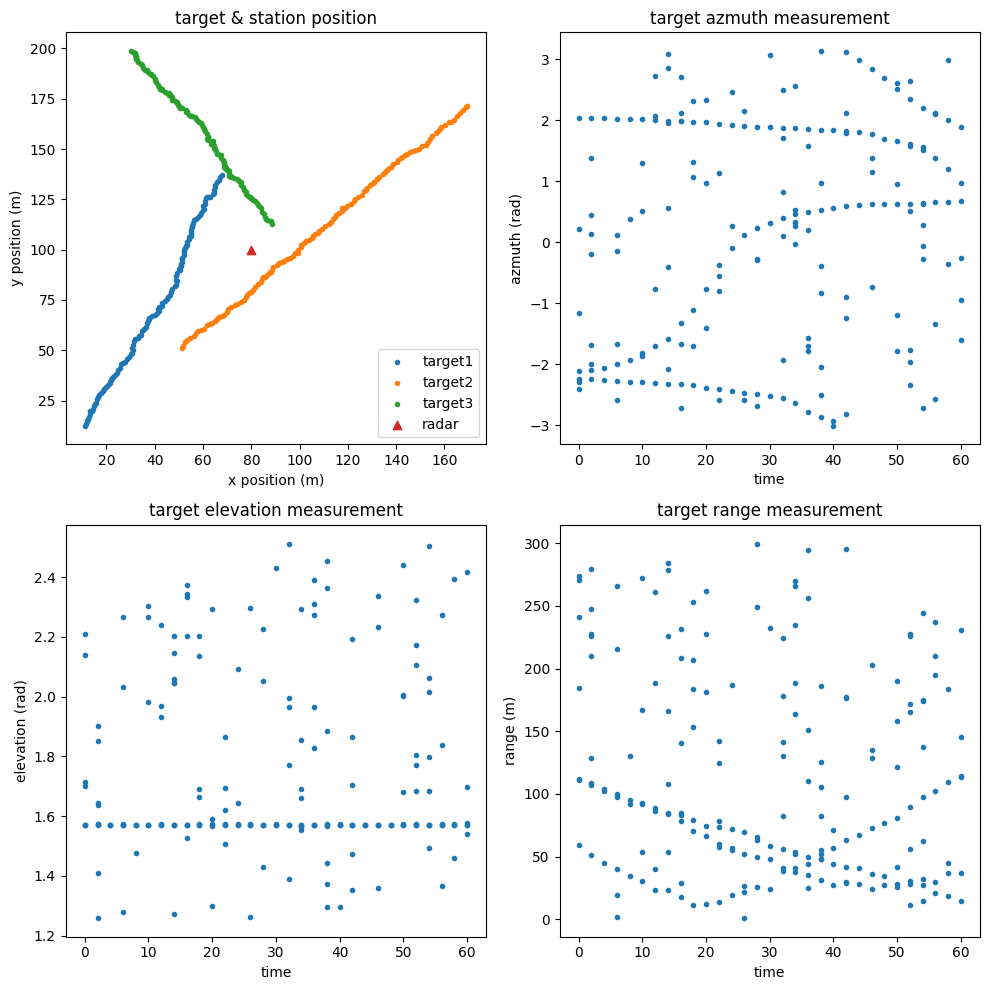

In [17]:
sim_records = sim.run()

fig, axs = plt.subplots(2, 2)
fig.set_size_inches((10, 10))

axs[0, 0].scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], marker=".", label="target1")
axs[0, 0].scatter(sim_records["lti_object3"]["x"], sim_records["lti_object3"]["y"], marker=".", label="target2")
axs[0, 0].scatter(sim_records["lti_object4"]["x"], sim_records["lti_object4"]["y"], marker=".", label="target3")
axs[0, 0].scatter(sim_records["lti_object1"]["x"][0], sim_records["lti_object1"]["y"][0], marker="^", label="radar")
axs[0, 0].set_title("target & station position")
axs[0, 0].set_xlabel("x position (m)")
axs[0, 0].set_ylabel("y position (m)")
axs[0, 0].legend()

axs[0, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_az"], marker=".")
axs[0, 1].set_title("target azmuth measurement")
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("azmuth (rad)")

axs[1, 0].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_el"], marker=".")
axs[1, 0].set_title("target elevation measurement")
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("elevation (rad)")

axs[1, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_rng"], marker=".")
axs[1, 1].set_title("target range measurement")
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("range (m)")

fig.tight_layout()

In [55]:
def get_F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F


def f(dt, x):
    return get_F(dt) @ x


def h(x):
    rho = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    the = np.arctan2(x[1], x[0])
    psi = np.arccos(x[2] / rho)

    if the > np.pi:
        the -= 2 * np.pi

    if psi > np.pi:
        psi -= np.pi

    if the < -np.pi:
        the += 2 * np.pi

    if psi < -np.pi:
        psi += np.pi
    
    return np.array([the, psi, rho])

def hinv(y):
    the = y[0]
    psi = y[1]
    rho = y[2]
    x = rho * np.sin(psi) * np.cos(the)
    y = rho * np.sin(psi) * np.sin(the)
    z = rho * np.cos(psi)

    return np.array([x, y, z, 0, 0, 0])


def get_H(X):
    x = X[0]
    y = X[1]
    z = X[2]
    
    return np.array([[-y/(x**2 + y**2), x/(x**2 + y**2), 0, 0, 0, 0],
                     [(x*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), (y*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), -(1/(x**2 + y**2 + z**2)**(1/2) - z**2/(x**2 + y**2 + z**2)**(3/2))/(1 - z**2/(x**2 + y**2 + z**2))**(1/2), 0, 0, 0],
                     [x/(x**2 + y**2 + z**2)**(1/2), y/(x**2 + y**2 + z**2)**(1/2), z/(x**2 + y**2 + z**2)**(1/2), 0, 0, 0]
                    ])


def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q


In [56]:

t1 = np.where(sim_records["radar1"]["target_id"] == 2)
t2 = np.where(sim_records["radar1"]["target_id"] == 3)
t3 = np.where(sim_records["radar1"]["target_id"] == 4)


x1_hat_0 = hinv([sim_records["radar1"]["target_az"][t1[0][0]],
                sim_records["radar1"]["target_el"][t1[0][0]],
                sim_records["radar1"]["target_rng"][t1[0][0]]])

x2_hat_0 = hinv([sim_records["radar1"]["target_az"][t2[0][0]],
                sim_records["radar1"]["target_el"][t2[0][0]],
                sim_records["radar1"]["target_rng"][t2[0][0]]])

x3_hat_0 = hinv([sim_records["radar1"]["target_az"][t3[0][0]],
                sim_records["radar1"]["target_el"][t3[0][0]],
                sim_records["radar1"]["target_rng"][t3[0][0]]])


P_hat_0 = 1e9 * np.eye(6)


kf1 = ExtendedKalman(x1_hat_0, P_hat_0, f, get_F, h, get_H, Q, R)
kf2 = ExtendedKalman(x2_hat_0, P_hat_0, f, get_F, h, get_H, Q, R)
kf3 = ExtendedKalman(x2_hat_0, P_hat_0, f, get_F, h, get_H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        if m.target_id == 2:
            kf2.update(m)
        elif m.target_id == 3:
            kf2.update(m)
        elif m.target_id == 4:
            kf3.update(m)

kf1_record = kf2.record()
kf2_record = kf2.record()
kf3_record = kf3.record()


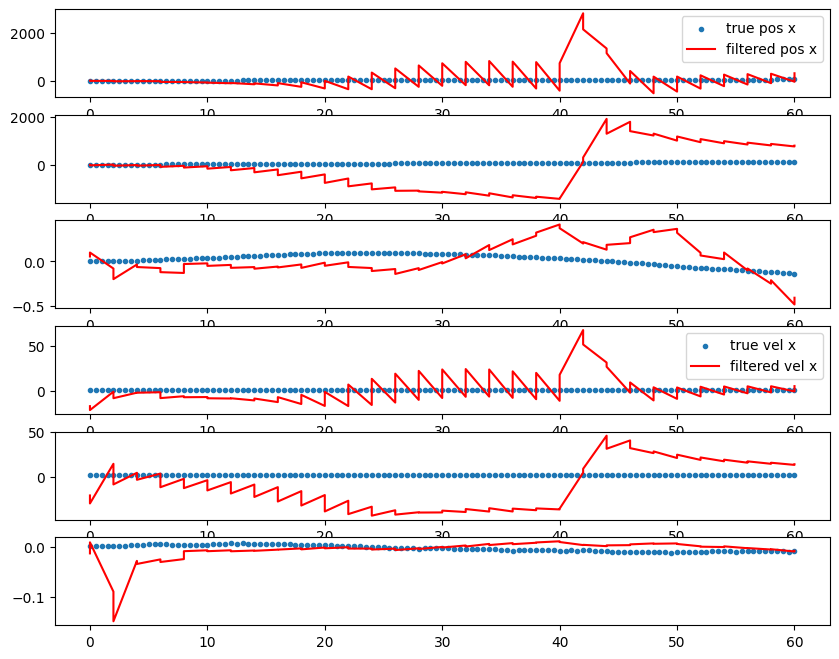

In [57]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].plot(kf1_record["t"], sim_records["lti_object1"]["x"][0] + kf1_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].plot(kf1_record["t"], sim_records["lti_object1"]["y"][0] + kf1_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].plot(kf1_record["t"], sim_records["lti_object1"]["z"][0] + kf1_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf1_record["t"], kf1_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf1_record["t"], kf1_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf1_record["t"], kf1_record["x_hat"][:, 5], color="red", label="filtered pos z")

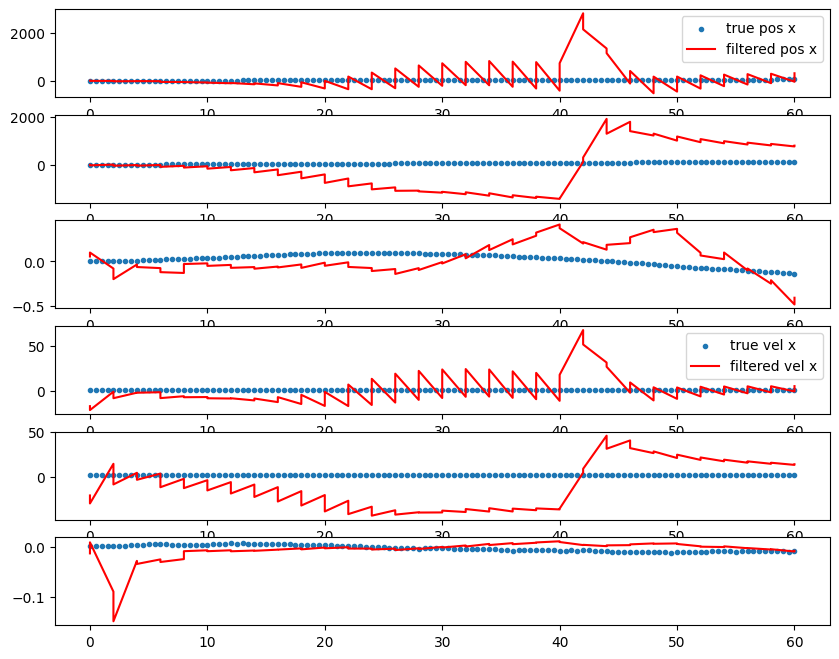

In [58]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].plot(kf2_record["t"], sim_records["lti_object1"]["x"][0] + kf2_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].plot(kf2_record["t"], sim_records["lti_object1"]["y"][0] + kf2_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].plot(kf2_record["t"], sim_records["lti_object1"]["z"][0] + kf2_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf2_record["t"], kf2_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf2_record["t"], kf2_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf2_record["t"], kf2_record["x_hat"][:, 5], color="red", label="filtered pos z")

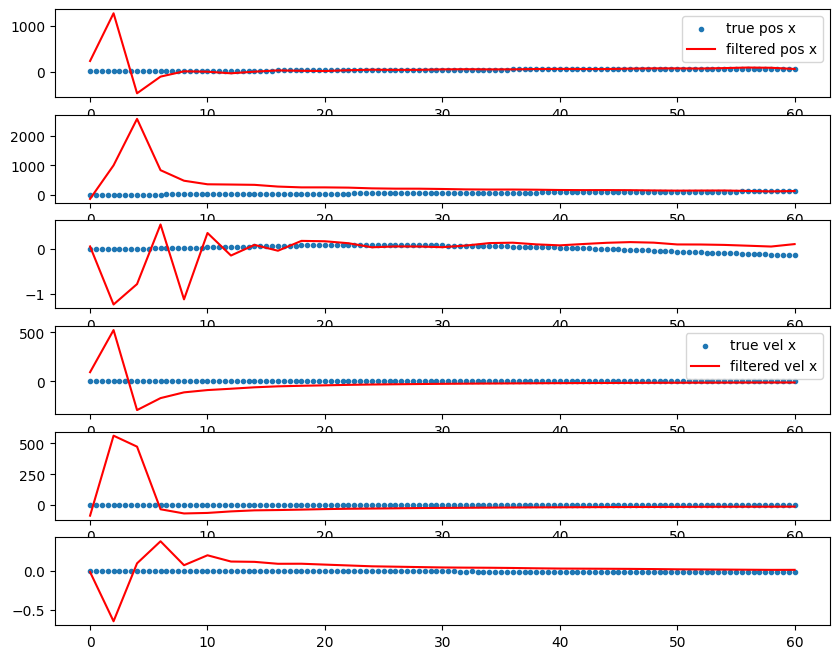

In [59]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].plot(kf3_record["t"], sim_records["lti_object1"]["x"][0] + kf3_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].plot(kf3_record["t"], sim_records["lti_object1"]["y"][0] + kf3_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].plot(kf3_record["t"], sim_records["lti_object1"]["z"][0] + kf3_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf3_record["t"], kf3_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf3_record["t"], kf3_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf3_record["t"], kf3_record["x_hat"][:, 5], color="red", label="filtered pos z")

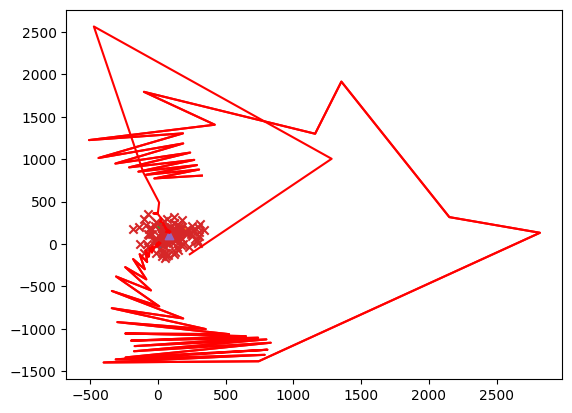

In [60]:
Ny = sim_records["radar1"]["t"].shape[0]

x_meas = np.zeros((Ny, 3))

for i in range(Ny):
    x_meas[i] = hinv([sim_records["radar1"]["target_az"][i],
                      sim_records["radar1"]["target_el"][i],
                      sim_records["radar1"]["target_rng"][i]])[:3]

plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"])
plt.scatter(sim_records["lti_object3"]["x"], sim_records["lti_object3"]["y"])
plt.scatter(sim_records["lti_object4"]["x"], sim_records["lti_object4"]["y"])

plt.scatter(sim_records["lti_object1"]["x"][0] + x_meas[:, 0],
            sim_records["lti_object1"]["y"][0] + x_meas[:, 1], marker="x")
plt.plot(sim_records["lti_object1"]["x"][0] + kf1_record["x_hat"][:, 0],
            sim_records["lti_object1"]["y"][0] + kf1_record["x_hat"][:, 1], color="red")
plt.plot(sim_records["lti_object1"]["x"][0] + kf2_record["x_hat"][:, 0],
            sim_records["lti_object1"]["y"][0] + kf2_record["x_hat"][:, 1], color="red")
plt.plot(sim_records["lti_object1"]["x"][0] + kf3_record["x_hat"][:, 0],
            sim_records["lti_object1"]["y"][0] + kf3_record["x_hat"][:, 1], color="red")
plt.scatter(sim_records["lti_object1"]["x"][0],
            sim_records["lti_object1"]["y"][0], marker="^")